# Import/install libraries

In [1]:
#Other
import os
import pandas as pd
import re
import pickle
import numpy as np
import time

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Text pre-procesing
from stop_words import get_stop_words
import snowballstemmer


#preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier

#Analysis/Optimization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from Modules import *

In [2]:
pd.options.display.max_colwidth = 1000

# Load data

In [3]:
data_root = os.path.join("/workspace/academy/assignment1", "data")

In [4]:
df_train = pd.read_parquet(os.path.join(data_root, "train.parquet"))

In [5]:
df_test = pd.read_parquet(os.path.join(data_root, "test.parquet"))

## Looking at loaded data

In [6]:
df_train.shape

(3861, 8)

In [7]:
df_test.shape

(946, 4)

In [8]:
df_train.head(3)

,uuid,description,color,price,cc3,sparkling,floral,striped
0,00_06db4_f7PKCScjE7iz9RccgKoYU8BG,beautiful summer dress by zara only worn once.\n\n#zara #zarawoman #zaradress #summerdress #dress,VARIOUS,8.4,DRESSES,False,True,False
1,00_074fe_d1wi5P39YxXsM3aYJWdToH2p,Maroon denim colored high rise jean shorts from Charlotte Russe size 2. Fits sizes 25-26 and goes up to right under belly button on a 5”7 tall person. Shorts are in good condition but there is slight wear as pictured in the back,BROWN,3.8,SHORTS_CAPRIS,False,False,False
2,0746f_viq17Xw4gBvYbmB1qKD5z6Z8,brand-new without tags x,VARIOUS,7.2,SHORTS_CAPRIS,False,True,False


# Analysis of Training data

### General info

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3861 entries, 0 to 3277
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         3861 non-null   object 
 1   description  3861 non-null   object 
 2   color        3861 non-null   object 
 3   price        3861 non-null   float64
 4   cc3          3488 non-null   object 
 5   sparkling    3861 non-null   bool   
 6   floral       3861 non-null   bool   
 7   striped      3861 non-null   bool   
dtypes: bool(3), float64(1), object(4)
memory usage: 192.3+ KB


In [10]:
df_train.isna().sum()

uuid             0
description      0
color            0
price            0
cc3            373
sparkling        0
floral           0
striped          0
dtype: int64

### Check for duplicate rows

In [11]:
df_train.duplicated().sum()

66

In [12]:
df_train[df_train.duplicated(keep=False).values].set_index("uuid").sort_index().head(4)

,description,color,price,cc3,sparkling,floral,striped
uuid,,,,,,,
00_04e32_uA8Gveq8Cr43y9A8p6FNWjeR,">> až 15% sleva na sety <<\n\nProužkované lesklé šatky s háčkovaným horním okrajem a ramínky, mají spodničku, dobře vypadají s nějakým páskem. Materiál 95% viskoza, 5% kovová vlákna, podšívka polyester.\nVelikost S odpovídá. Délka 114 cm.\n\n>> více info v profilu <<\n\n#boho #hippie #mididress # #shimmer #crochet #mustard #spring #summer #autumn #viscose #zara",RED,11.6700,DRESSES,True,False,True
00_04e32_uA8Gveq8Cr43y9A8p6FNWjeR,">> až 15% sleva na sety <<\n\nProužkované lesklé šatky s háčkovaným horním okrajem a ramínky, mají spodničku, dobře vypadají s nějakým páskem. Materiál 95% viskoza, 5% kovová vlákna, podšívka polyester.\nVelikost S odpovídá. Délka 114 cm.\n\n>> více info v profilu <<\n\n#boho #hippie #mididress # #shimmer #crochet #mustard #spring #summer #autumn #viscose #zara",RED,11.6700,DRESSES,True,False,True
00_04ef6_pn2b1ydpsrw2TQLriG1uLm5q,nové:) Da se použit i jako Tunika :) \n,BLUE,15.5211,DRESSES,False,False,True
00_04ef6_pn2b1ydpsrw2TQLriG1uLm5q,nové:) Da se použit i jako Tunika :) \n,BLUE,15.5211,DRESSES,False,False,True


### Delete duplication

In [13]:
df_train = df_train[~df_train.duplicated()]

## Analyse Column "uuid" (unique item ID)

### "uuid" should be unique

In [14]:
df_train["uuid"].value_counts().ge(2).sum()

10

### Have 10 dublicated rows, lets look how they look, becouse they weren't deleted as full row dublicates

In [15]:
dt_train_only_same_uuid = df_train[df_train.duplicated(subset=["uuid"], keep=False)].sort_values(by="uuid")
dt_train_only_same_uuid.head(4)

,uuid,description,color,price,cc3,sparkling,floral,striped
3007,00_04eaf_TVbYdLiveQeR7NruNvDBNF2Z,"prsa 38cm, délka 55cm, pružný",BROWN,3.89,None,False,False,True
3007,00_04eaf_TVbYdLiveQeR7NruNvDBNF2Z,"prsa 38cm, délka 55cm, pružný",BROWN,3.89,PULLOVERS_SWEATERS,False,False,True
1222,00_05414_gxmt8KnGmNoc2ngfV8goMSwf,- only worn a few times\n- destress at leg holes \n- some distress rips\nAny questions? Just contact me!,LIGHT-BLUE,5.32,SHORTS_CAPRIS,False,False,False
1222,00_05414_gxmt8KnGmNoc2ngfV8goMSwf,- only worn a few times\n- destress at leg holes \n- some distress rips\nAny questions? Just contact me!,LIGHT-BLUE,5.32,None,False,False,False


### It looks that only thing that different theme from being completely duplicate is "cc3" column with None values

In [16]:
df_train_no_cc3_duplic = df_train[df_train.loc[:, df_train.columns != "cc3"].duplicated(keep=False)].sort_values(by="uuid")
df_train_no_cc3_duplic.head(4)

,uuid,description,color,price,cc3,sparkling,floral,striped
3007,00_04eaf_TVbYdLiveQeR7NruNvDBNF2Z,"prsa 38cm, délka 55cm, pružný",BROWN,3.89,None,False,False,True
3007,00_04eaf_TVbYdLiveQeR7NruNvDBNF2Z,"prsa 38cm, délka 55cm, pružný",BROWN,3.89,PULLOVERS_SWEATERS,False,False,True
1222,00_05414_gxmt8KnGmNoc2ngfV8goMSwf,- only worn a few times\n- destress at leg holes \n- some distress rips\nAny questions? Just contact me!,LIGHT-BLUE,5.32,SHORTS_CAPRIS,False,False,False
1222,00_05414_gxmt8KnGmNoc2ngfV8goMSwf,- only worn a few times\n- destress at leg holes \n- some distress rips\nAny questions? Just contact me!,LIGHT-BLUE,5.32,None,False,False,False


### It looks the same, lets check it 

In [17]:
dt_train_only_same_uuid.equals(df_train_no_cc3_duplic)

True

### Remove from df_train rows with duplicated "uuid" and "cc3" == None

In [18]:
duplic_index = list(df_train_no_cc3_duplic[df_train_no_cc3_duplic["cc3"].isna()].index)

In [19]:
df_train.drop(duplic_index, inplace=True)

### Look again in "uuid" duplicates

In [20]:
df_train["uuid"].value_counts().ge(2).sum()

0

# Main columns for this assigment are "cc3" and "description"

## Column "cc3"

In [21]:
df_train_cc3 = df_train["cc3"].value_counts(normalize=True, dropna=False).reset_index()
df_train_cc3["index"].fillna("MISSING", inplace=True)
df_train_cc3

,index,cc3
0,DRESSES,0.440795
1,TROUSERS,0.135629
2,SHORTS_CAPRIS,0.125563
3,SKIRTS,0.116821
4,MISSING,0.096159
5,PULLOVERS_SWEATERS,0.085033


Text(0, 0.5, 'Category of the item')

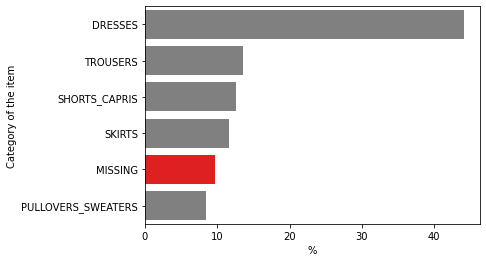

In [22]:
clrs = ["grey" if col_name != "MISSING" else "red" for col_name in df_train_cc3["index"].values]

sns.barplot(y=df_train_cc3["index"], x=df_train_cc3["cc3"] * 100, palette=clrs)
plt.xlabel("%")
plt.ylabel("Category of the item")

### Have a lot Missing data, almost the same amount as majority of other categories (except DRESSES)
#### For this time we delete all missing values

In [23]:
df_train.dropna(subset=["cc3"], inplace=True)

## Column "description"

### Pre-processing
Deleting stop-words(on, in etc.) and unrelavant characters (as emojis, #, etc.).
Reducing words to their word stem (ex. beautiful -> beauti )

In [24]:
VINTED_LANGUAGES = ["lithuanian", "polish", "czech", "french", "dutch", "german", "english", "spanish"]

In [25]:
def stop_word_generator(languages):
    """
        languages: list of languages
        
        return: set of stop words
    """
    all_stop_words = []
    for language in languages:
        try:
             stop_words = get_stop_words(language)
        except:
            pass
        else:
            all_stop_words += stop_words
    return set(all_stop_words)

In [26]:
STOPWORDS = stop_word_generator(VINTED_LANGUAGES)

In [27]:
def clean_text(text, stop_words):
#     global STOPWORDS
    """
        text: a string
        
        return: modified initial string
    """
    stemmer = snowballstemmer.stemmer('english')
    text = text.lower()
    text = re.sub(r"\d", " ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\b\w{1,3}\b", " ", text)
    text = " ".join(stemmer.stemWords((word for word in text.split() if word not in stop_words)))

    return text
    

In [28]:
df_train["description_proc"] = df_train["description"].apply(clean_text, stop_words=STOPWORDS)

In [29]:
df_train[["description", "description_proc"]].head()

,description,description_proc
0,beautiful summer dress by zara only worn once.\n\n#zara #zarawoman #zaradress #summerdress #dress,beauti summer dress zara worn zara zarawoman zaradress summerdress dress
1,Maroon denim colored high rise jean shorts from Charlotte Russe size 2. Fits sizes 25-26 and goes up to right under belly button on a 5”7 tall person. Shorts are in good condition but there is slight wear as pictured in the back,maroon denim color high rise jean short charlott russ size fit size goe right belli button tall person short good condit slight wear pictur back
2,brand-new without tags x,brand without tag
3,"Vasariška trumpa lengva medvilninė suknytė, be defektų.\nIlgis 83cm, plotis tarp pažastų 37cm.\n#terranova #suknele #geleta",vasariška trumpa lengva medvilninė suknytė defektų ilgi ploti tarp pažastų terranova suknel geleta
4,"size small, worn; distressed look. one has a pain stain, see pics \nWILL THROW IN FREE W ANY BUNDLE IF ASKED \n#jsfcloset",size small worn distress look pain stain pic throw free bundl ask jsfcloset


### Counting Pre-processed description words

In [30]:
df_train["escription_proc_len"] = df_train["description_proc"].str.split().str.len()

In [31]:
df_train["escription_proc_len"].value_counts().head(10)

5     217
2     214
4     214
6     214
3     205
7     194
8     178
10    160
9     157
11    130
Name: escription_proc_len, dtype: int64

#### Delete rows that don't have any description

In [32]:
df_train = df_train[~(df_train['escription_proc_len'] == 0)]

In [33]:
df_train.to_csv(os.path.join(data_root, "train_preproc.csv"), index=False)

# Clasification model

### Split data to train/test

In [34]:
X = df_train['description_proc']
y = df_train['cc3']
X.shape
#TO DO proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Analysing most decents models

### Testing models

In [35]:
def predict_top2(clf_top2, X_train, y_train, X_test, y_test):
    
    clf_top2.fit(X_train, y_train)

    probs = clf_top2.predict_proba(X_test)

    y_pred_top2 = np.argsort(-probs, axis=1)[:,:2]
    
    y_pred1_2_prob = np.sort(probs,axis=1)[:,-2:]
    y_pred1_prob = y_pred1_2_prob[:, 1]
    y_pred2_prob = y_pred1_2_prob[:, 0]
    
    y_pred1 = clf_top2.classes_[y_pred_top2][:,0]
    y_pred2 = clf_top2.classes_[y_pred_top2][:,1]
    
    acc_top2 = (sum(y_pred1 == np.array(y_test)) + sum(y_pred2 == np.array(y_test))) / y_test.shape[0]
    
    return acc_top2 , y_pred1, y_pred2, y_pred1_prob, y_pred2_prob

In [36]:
#Quick Data prediction Pipeline
def quick_pipeline(clf, text, X_train, X_test, y_train, y_test, plot=True, return_type = None):
    
    clf_pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
             ('clf', clf()),
            ])
    
    clf_pipe.fit(X_train, y_train)
    
    y_pred = clf_pipe.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if plot:
    
        print(text +'\n')
        print( 'accuracy: ' +  str(acc) + '\n')
        
        plot_confusion_matrix(clf_pipe, X_test, y_test, normalize="true", xticks_rotation="vertical", cmap="Blues")
        plt.grid(False)
        plt.show()


        print('\n'*2)
        print('-'*60)
        print(classification_report(y_test, y_pred, target_names=y_test.unique()))
        report = classification_report(y_test, y_pred, target_names=y_test.unique(),output_dict=True)
        print('-'*60)
        print('\n')
    else:
        report = classification_report(y_test, y_pred, target_names=y_test.unique(),output_dict=True)
        
        
    acc_top2 , y_pred1, y_pred2, y_pred1_prob, y_pred2_prob = predict_top2(clf_pipe, X_train, y_train, X_test, y_test)
    
    
    if return_type == 'stats':
    
        return acc, acc_top2, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']
    
    elif return_type == 'classifier':
        
        return clf_pipe
    
    elif return_type == 'predictions':
    
        return y_pred1, y_pred2, y_pred1_prob, y_pred2_prob
    
    else:
        return None

In [37]:
#Define models
models_dict = {'MultinomialNB': MultinomialNB,                           # supports .pred_proba() through Pipeline
              #'SGDClassifier' : SGDClassifier,                          # supports .pred_proba() if loss = 'hinge'
              #'SVC' : SVC,                                              # supports .pred_proba() if probability=True
              #'LinearSVC' : LinearSVC,                                  # Does not support
              'LogisticRegression' : LogisticRegression,                 # supports .pred_proba()
              'RandomForestClassifier' : RandomForestClassifier,         # supports .pred_proba()
              'GradientBoostingClassifier' : GradientBoostingClassifier, # supports .pred_proba()
              'AdaBoostClassifier' : AdaBoostClassifier,                 # supports .pred_proba()
              'ExtraTreeClassifier' : ExtraTreeClassifier                # supports .pred_proba()
             }

MultinomialNB

accuracy: 0.5513196480938416



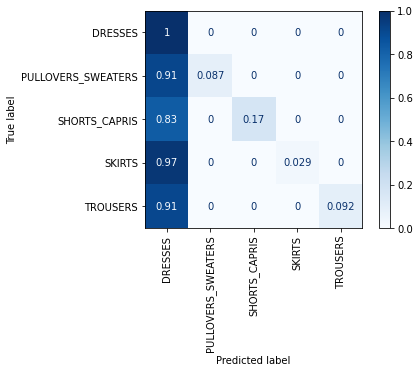




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.53      1.00      0.69       345
          TROUSERS       1.00      0.09      0.16        46
            SKIRTS       1.00      0.17      0.29        89
     SHORTS_CAPRIS       1.00      0.03      0.06       104
PULLOVERS_SWEATERS       1.00      0.09      0.17        98

          accuracy                           0.55       682
         macro avg       0.91      0.28      0.27       682
      weighted avg       0.76      0.55      0.43       682

------------------------------------------------------------


LogisticRegression

accuracy: 0.749266862170088



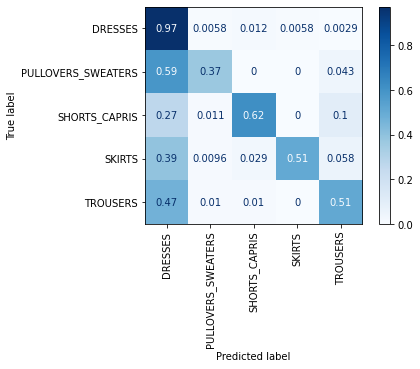




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.71      0.97      0.82       345
          TROUSERS       0.77      0.37      0.50        46
            SKIRTS       0.87      0.62      0.72        89
     SHORTS_CAPRIS       0.96      0.51      0.67       104
PULLOVERS_SWEATERS       0.74      0.51      0.60        98

          accuracy                           0.75       682
         macro avg       0.81      0.60      0.66       682
      weighted avg       0.78      0.75      0.73       682

------------------------------------------------------------


RandomForestClassifier

accuracy: 0.7551319648093842



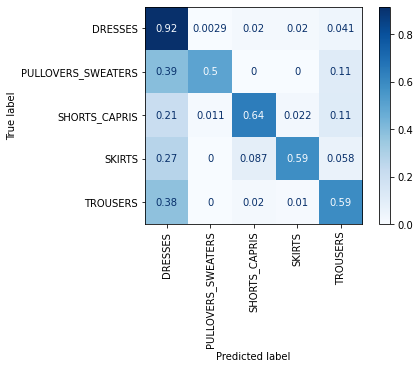




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.76      0.92      0.83       345
          TROUSERS       0.92      0.50      0.65        46
            SKIRTS       0.76      0.64      0.70        89
     SHORTS_CAPRIS       0.86      0.59      0.70       104
PULLOVERS_SWEATERS       0.62      0.59      0.61        98

          accuracy                           0.76       682
         macro avg       0.78      0.65      0.70       682
      weighted avg       0.76      0.76      0.75       682

------------------------------------------------------------


GradientBoostingClassifier

accuracy: 0.7712609970674487



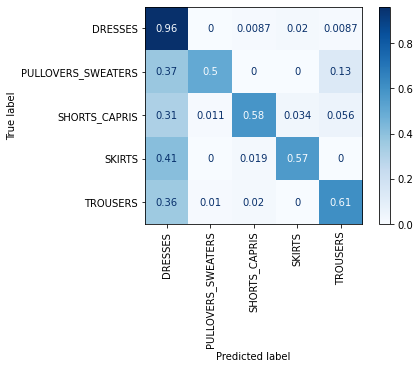




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.73      0.96      0.83       345
          TROUSERS       0.92      0.50      0.65        46
            SKIRTS       0.88      0.58      0.70        89
     SHORTS_CAPRIS       0.86      0.57      0.68       104
PULLOVERS_SWEATERS       0.81      0.61      0.70        98

          accuracy                           0.77       682
         macro avg       0.84      0.65      0.71       682
      weighted avg       0.79      0.77      0.76       682

------------------------------------------------------------


AdaBoostClassifier

accuracy: 0.7595307917888563



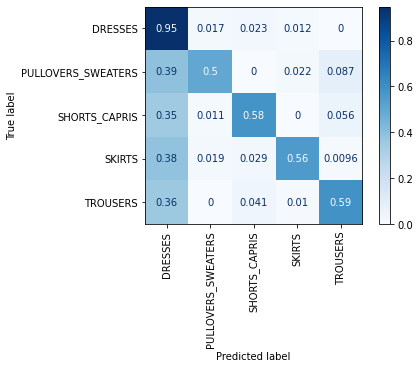




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.73      0.95      0.82       345
          TROUSERS       0.72      0.50      0.59        46
            SKIRTS       0.78      0.58      0.67        89
     SHORTS_CAPRIS       0.91      0.56      0.69       104
PULLOVERS_SWEATERS       0.85      0.59      0.70        98

          accuracy                           0.76       682
         macro avg       0.80      0.64      0.69       682
      weighted avg       0.78      0.76      0.75       682

------------------------------------------------------------


ExtraTreeClassifier

accuracy: 0.5982404692082112



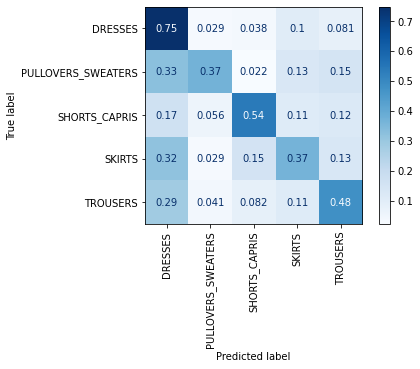




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.74      0.75      0.74       345
          TROUSERS       0.44      0.37      0.40        46
            SKIRTS       0.56      0.54      0.55        89
     SHORTS_CAPRIS       0.38      0.37      0.37       104
PULLOVERS_SWEATERS       0.44      0.48      0.46        98

          accuracy                           0.60       682
         macro avg       0.51      0.50      0.50       682
      weighted avg       0.60      0.60      0.60       682

------------------------------------------------------------




In [38]:
#Run all models
results = pd.DataFrame(columns=['model','acc_top1', 'acc_top2','precission','recall','f1_score'])

for name, clf in models_dict.items():
    acc, acc_top2, precission, recall, fi_score = quick_pipeline(clf, name, X_train, X_test, y_train, y_test, plot=True, return_type = 'stats')
    idx = results.shape[0]
    results.loc[idx] = [name, acc, acc_top2, precission, recall, fi_score]

## Performaces of the models

In [39]:
results_ = results.sort_values(by=['acc_top2','precission'],ascending=False).reset_index(drop=True)
results_.style.set_precision(2)

,model,acc_top1,acc_top2,precission,recall,f1_score
0,LogisticRegression,0.75,0.87,0.78,0.75,0.73
1,RandomForestClassifier,0.76,0.86,0.76,0.76,0.75
2,GradientBoostingClassifier,0.77,0.86,0.79,0.77,0.76
3,AdaBoostClassifier,0.76,0.85,0.78,0.76,0.75
4,MultinomialNB,0.55,0.84,0.76,0.55,0.43
5,ExtraTreeClassifier,0.60,0.76,0.60,0.60,0.60


### Choosing the best model by top2 accuracy and top1 precission

In [40]:
best_model_name = results_['model'][0]
best_model = models_dict[best_model_name]

LogisticRegression

accuracy: 0.749266862170088



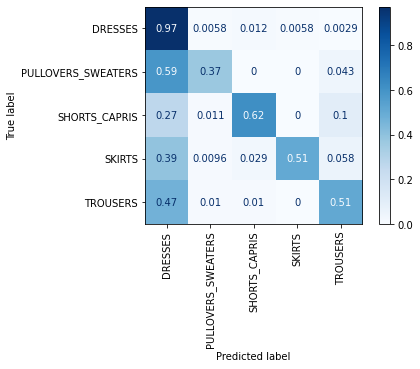




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.71      0.97      0.82       345
          TROUSERS       0.77      0.37      0.50        46
            SKIRTS       0.87      0.62      0.72        89
     SHORTS_CAPRIS       0.96      0.51      0.67       104
PULLOVERS_SWEATERS       0.74      0.51      0.60        98

          accuracy                           0.75       682
         macro avg       0.81      0.60      0.66       682
      weighted avg       0.78      0.75      0.73       682

------------------------------------------------------------




In [41]:
clf_pipe = quick_pipeline(best_model, best_model_name, X_train, X_test, y_train, y_test, plot=True, return_type = 'classifier')

### Save Best model with Pickle

In [42]:
filename = 'Baseline_model2.pkl'
with open(filename, 'wb') as file:
    pickle.dump(clf_pipe, file)

## Model evaluation

In [43]:
df_eval = pd.concat([X_test, y_test], axis=1)
(df_eval["category1"], 
df_eval["category2"], 
df_eval["category1_prob"],
df_eval["category2_prob"]) = (quick_pipeline(best_model,
                                              best_model_name, X_train, X_test,
                                              y_train, y_test, plot=False,
                                              return_type ='predictions')
                              )





### Test data shape

In [94]:
df_eval.shape

(682, 6)

### Failed predictions

In [101]:
guessed_first = (df_eval["cc3"] != df_eval["category1"])
guessed_second = (df_eval["cc3"] != df_eval["category2"])
                 
df_bad_pred = df_eval[guessed_first & guessed_second].sort_values(by=["category1_prob", "category2_prob"], ascending=False)

In [57]:
df_bad_pred.head(20)

,description_proc,cc3,category1,category2,category1_prob,category2_prob
2343,pretti crop trouser hard worn,SHORTS_CAPRIS,TROUSERS,DRESSES,0.815500,0.074387
2632,length,TROUSERS,DRESSES,SKIRTS,0.676106,0.128825
2303,post royal mail everi friday light perfect summer possibl crop jean size trouser,SHORTS_CAPRIS,TROUSERS,DRESSES,0.674353,0.106392
2485,perfect jean dress skirt pinafor,PULLOVERS_SWEATERS,DRESSES,SKIRTS,0.610235,0.275727
3048,look size great condit criss cross side short make offer,SKIRTS,SHORTS_CAPRIS,DRESSES,0.599205,0.195060
1470,tag blush pink print lacey around outer edg accept reason offer,PULLOVERS_SWEATERS,DRESSES,TROUSERS,0.588626,0.135049
1435,bought holiday didn chanc wear brand without tag button front,SKIRTS,DRESSES,TROUSERS,0.557061,0.152595
1216,velikost odpovídá,SKIRTS,DRESSES,TROUSERS,0.547976,0.183001
2660,without tag,SKIRTS,DRESSES,SHORTS_CAPRIS,0.544808,0.178943
2083,size immacul condit post hour monday friday free postag order discount bundl shop polici found profil smart casual workwear summer spring autumn winter topshop riverisland zara next newlook whistl hobb primark vintag karenmillen reiss debenham pimki bershka mango aso papaya principl peruna missguid missselfridg georg monsoon veromoda,SKIRTS,DRESSES,TROUSERS,0.520033,0.151167


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 90.0)

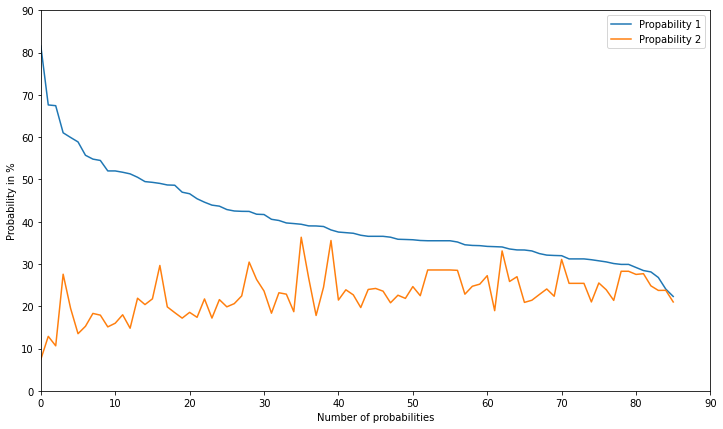

In [77]:
plt.figure(figsize=(12,7))
sns.lineplot(range(len(df_bad_pred["category1"])), df_bad_pred["category1_prob"] * 100, label="Propability 1")
sns.lineplot(range(len(df_bad_pred["category2"])), df_bad_pred["category2_prob"] * 100, label="Propability 2")

plt.xlabel("Number of probabilities")
plt.ylabel("Probability in %")
plt.xlim(0, 90)
plt.ylim(0, 90)

### Predicted with first guess (DRESSES)

In [99]:
df_pred_dress = df_eval[(df_eval["cc3"] == df_eval["category1"]) & (df_eval["cc3"] == "DRESSES")].sort_values(by=["category1_prob", "category2_prob"], ascending=False)

In [83]:
df_pred_dress.head()

,description_proc,cc3,category1,category2,category1_prob,category2_prob
1791,summer dress,DRESSES,DRESSES,SHORTS_CAPRIS,0.999637,0.000117
2653,dress good condit perfect summer dress dress print summerdress size,DRESSES,DRESSES,SHORTS_CAPRIS,0.999234,0.000208
321,sleev dress,DRESSES,DRESSES,PULLOVERS_SWEATERS,0.998033,0.001704
3337,summer dress worn size,DRESSES,DRESSES,SHORTS_CAPRIS,0.997872,0.000872
3476,size small summer dress,DRESSES,DRESSES,SHORTS_CAPRIS,0.995479,0.001375


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 100.0)

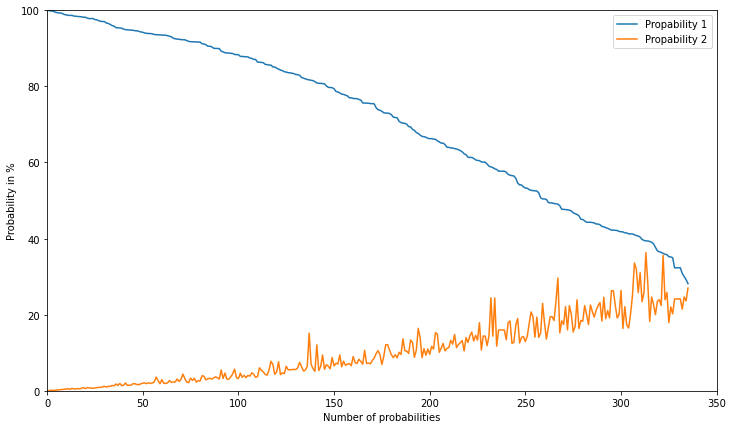

In [87]:
plt.figure(figsize=(12,7))
sns.lineplot(range(len(df_pred_dress["category1"])), df_pred_dress["category1_prob"] * 100, label="Propability 1")
sns.lineplot(range(len(df_pred_dress["category2"])), df_pred_dress["category2_prob"] * 100, label="Propability 2")

plt.xlabel("Number of probabilities")
plt.ylabel("Probability in %")
plt.xlim(0, 350)
plt.ylim(0, 100)

### Predicted with first guess (TROUSERS)

In [102]:
df_pred_trous = df_eval[(df_eval["cc3"] == df_eval["category1"]) & (df_eval["cc3"] == "TROUSERS")].sort_values(by=["category1_prob", "category2_prob"], ascending=False).head()

In [89]:
df_pred_trous.head()

,description_proc,cc3,category1,category2,category1_prob,category2_prob
2889,trouser comfi,TROUSERS,TROUSERS,DRESSES,0.891964,0.035921
1344,smart navi white stripe trouser size generous like pleat front side pocket wide leg great summer weight work trouser,TROUSERS,TROUSERS,DRESSES,0.872219,0.046940
3672,lipsi leather trouser shini trouser metal blue go size brand,TROUSERS,TROUSERS,DRESSES,0.854710,0.063340
1845,checker trouser worn primark size,TROUSERS,TROUSERS,DRESSES,0.808764,0.070632
1373,hollist trouser size high waist stretchi waist worn coupl time,TROUSERS,TROUSERS,SHORTS_CAPRIS,0.781398,0.108706


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 100.0)

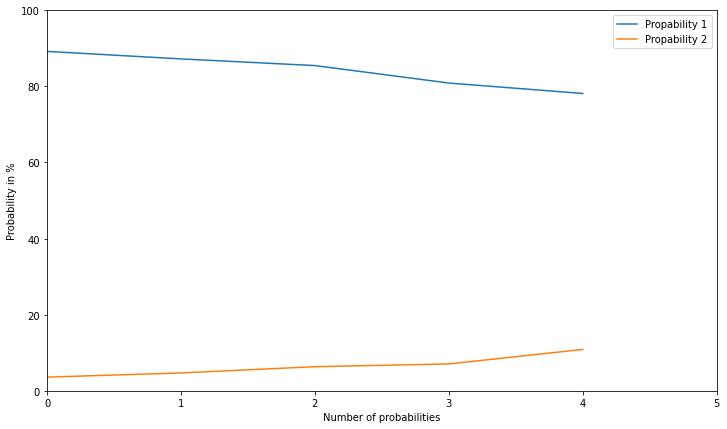

In [93]:
plt.figure(figsize=(12,7))
sns.lineplot(range(len(df_pred_trous["category1"])), df_pred_trous["category1_prob"] * 100, label="Propability 1")
sns.lineplot(range(len(df_pred_trous["category2"])), df_pred_trous["category2_prob"] * 100, label="Propability 2")

plt.xlabel("Number of probabilities")
plt.ylabel("Probability in %")
plt.xlim(0, 5)
plt.ylim(0, 100)

#### TROUSERS bad predictions

In [112]:
(
    df_eval[(df_eval["cc3"] == "TROUSERS") & ((df_eval["cc3"] != df_eval["category1"]) & (df_eval["cc3"] != df_eval["category2"]))]
             .sort_values(by=["category1_prob", "category2_prob"], ascending=False).head()
)

,description_proc,cc3,category1,category2,category1_prob,category2_prob
2632,length,TROUSERS,DRESSES,SKIRTS,0.676106,0.128825
1247,worn time henc flatter,TROUSERS,DRESSES,SHORTS_CAPRIS,0.486821,0.198448
1865,size good condit stretchi comfi materi flatter,TROUSERS,DRESSES,SHORTS_CAPRIS,0.428715,0.198625
2206,worn great condit size,TROUSERS,DRESSES,SHORTS_CAPRIS,0.393881,0.363191
1598,bought alter state worn size small elast waist band cute flatter,TROUSERS,DRESSES,SHORTS_CAPRIS,0.390054,0.266784


In [ ]:
pd.set_option('max_colwidth', 400)
df_pred_trous = df_eval[(df_eval["cc3"] == df_eval["category1"]) & (df_eval["cc3"] == "TROUSERS")].sort_values(by=["category1_prob", "category2_prob"], ascending=False).head()

### Predicted with first guess (SKIRTS)

In [103]:
df_pred_skirt = df_eval[(df_eval["cc3"] == df_eval["category1"]) & (df_eval["cc3"] == "SKIRTS")].sort_values(by=["category1_prob", "category2_prob"], ascending=False).head()

In [97]:
df_pred_skirt.head()

,description_proc,cc3,category1,category2,category1_prob,category2_prob
3530,midi denim skirt,SKIRTS,SKIRTS,DRESSES,0.971537,0.016451
2619,cute skirt leopard skirt high front back black skirt line chiffon materi elast waist great condit forev size small,SKIRTS,SKIRTS,DRESSES,0.964174,0.017509
733,black white skirt,SKIRTS,SKIRTS,DRESSES,0.961577,0.016492
3106,comfi denim skirt,SKIRTS,SKIRTS,SHORTS_CAPRIS,0.938938,0.027378
3283,high waist light blue denim mini skirt condit size,SKIRTS,SKIRTS,SHORTS_CAPRIS,0.884448,0.071581


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 100.0)

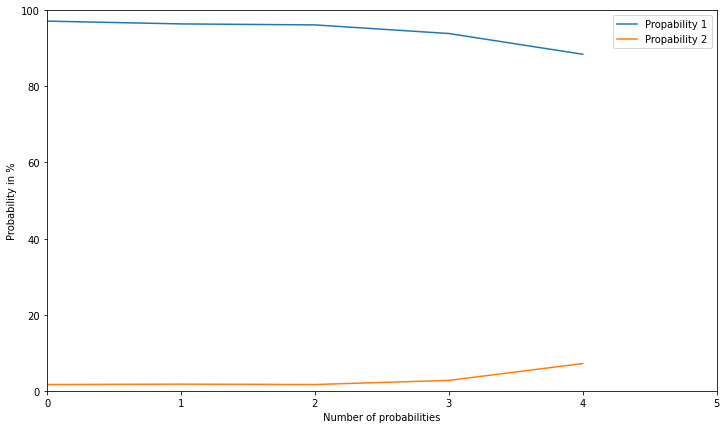

In [113]:
plt.figure(figsize=(12,7))
sns.lineplot(range(len(df_pred_skirt["category1"])), df_pred_skirt["category1_prob"] * 100, label="Propability 1")
sns.lineplot(range(len(df_pred_skirt["category2"])), df_pred_skirt["category2_prob"] * 100, label="Propability 2")

plt.xlabel("Number of probabilities")
plt.ylabel("Probability in %")
plt.xlim(0, 5)
plt.ylim(0, 100) 

## Running baseline Model on test data

In [48]:
dataframe = pd.read_parquet(os.path.join(data_root, "test.parquet"))
dataframe.shape

(946, 4)

In [49]:
t = time.time()
clf = Classifier_pipe(dataframe, 'description', 'Baseline_model2.pkl')
clf.predict_top2()
print(f'total time: {time.time() - t:.3f} s')

preprocess : 1.120 s
inference  : 0.017 s
saving     : 0.023 s
total time: 1.169 s


### Lets look at predicted labels

In [53]:
df_temp = pd.read_parquet('predictions.parquet')
df_temp.head(10)

,uuid,description,color,price,category1,category2
0,00_04fec_bcBubyJW2q8o6JPFntUn4Q9W,"In great condition! No holes, stains or pilling. \n\nSize 26. \n\nStyle is Skinny Toothpick. \n\nMade of 99% cotton, 1% spandex. \n\nSmoke free home. All sales are final.\n\n#jcrew\n#corduroy\n#skinnyjeans",GREY,11.4000,TROUSERS,DRESSES
1,00_050a7_o9o8NLTcXJ7Hqs2t31xEGoG4,"šiek tiek praires užtrauktukas ,reiktų šiek tiek\nsuimt su siūlu . ne auksteniai nei 170cm \nPrašau neprašykite išmatavimų nuo pažasties iki klyno ir pan. Visi dydžiai yra standartiniai ,jei neparašyta kitaip. Nemainau.",WHITE,5.0000,DRESSES,TROUSERS
2,00_060f0_zLp2b8moCnfWX614ZAu8HfsS,This square neckline dress is so beautiful! It’s sheer and printed. It’s a pretty turquoise blue color. The back ties. It’s asymmetrical and ruched at one side. The brand is Cabi. Size small.,BLUE,26.6000,DRESSES,SKIRTS
3,00_05d49_74iqVSd8yami4Szoy5tBjkGF,"Maxi sukně ze zajímavého materiálu, tak trošku mění barvu na světle. Vysoký pas. Super objem, skoro princeznovská:)\n\n#dlouhasukne #maxisukne #sukne #zajímavý #zajímavá #zajimavabarva #material #lesklý #lesklá #extravagantni",PINK,4.6680,SKIRTS,DRESSES
4,00_06301_twfaovSeAmiJoFPWgAE9b99G,"Labai graži suknelė, yra maža dėmelė,kuri tikrak išsiplaus",BLACK,5.0000,DRESSES,SKIRTS
5,0657b_ekzpmzqL7oBv5oXYEG2k97TM,"příjemná pružná viskoza, vhodné na běžné nošení, jako těhotenské, nebo i kojící, délka 100cm hrudník 2x58+ cm\nZNAČKA: NEXT\nVELIKOST: 46",WHITE,9.6861,DRESSES,TROUSERS
6,06a1d_nZKKntEeKSQ8Kv45ymvw4zFB,Purple Papaya Denim Jeggings\nWorn few times\nIn great condition,PURPLE,1.8000,SHORTS_CAPRIS,DRESSES
7,00_04e38_dCq1Da2WcC9pprqP2AzR4pcw,"Labai graži, nauja suknelė eu 36 d. Uk 8d. Su blizgučiu. 92% polesteris, 4% elastanas",BODY,12.0000,DRESSES,SKIRTS
8,00_06664_ZAsYsk3pPhFsKoDFmwNUvACW,"Letní teplákové pruhované šaty H&M, velikost XS, velice příjemné s postranními kapsami",GREY,3.8900,DRESSES,TROUSERS
9,00_0685a_iDRZjgbPPBKhzKr9WHRi5DJk,"Krátké pruhované bavlněné šatky, super stav - nošené, ale bez vad. Hodně elastické, délka nad kolena. Neunosím.",BODY,3.8900,DRESSES,TROUSERS
